In [1]:
!pip install sentence_transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader

from utils import weights_init
from discriminatorModel import Embedding, Discriminator
from generatorModel import Generator
from preprocessing import Text2ImageDataset

import os
import time
import imageio
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

def process_caption(text):
    # Encode text and get model output
    embeddings = model.encode(text)
    ouput = np.expand_dims(embeddings, axis=0)
    return ouput

In [5]:
# Setting device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

Using Device cuda


In [6]:
date = datetime.now().strftime('%Y%m%d')
start_time = time.time()

In [7]:
# directory to store output images
output_save_path = '/content/drive/MyDrive/generated_images_128_new_banget/'
os.makedirs(output_save_path, exist_ok=True)

In [8]:
# directory to store trained models
model_save_path = '/content/drive/MyDrive/saved_models_128_new_banget/'
os.makedirs(model_save_path, exist_ok=True)

In [9]:
# setting up parameters
noise_dim = 100
embed_dim = 384
embed_out_dim = 128
batch_size = 16 #128
real_label = 1.
fake_label = 0.
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 250

In [10]:
train_dataset = Text2ImageDataset('/content/drive/MyDrive/CUHKSZ_Photos_reduced_128_new_lanzcos')
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False)
print("No of batches: ",len(train_loader))

No of batches:  9


In [20]:
# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

D_losses = []
G_losses = []

D_real_losses = []
D_wrong_losses = []
D_fake_losses = []

G_fake_losses = []
G_c1_losses = []
G_c2_losses = []

In [21]:
# initializing generator
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [22]:
# initializing discriminator
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13):

In [23]:
# setting up Adam optimizer for Generator and Discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [24]:
# training loop

# iterating over number of epochs
# for epoch in range(num_epochs):
for epoch in range(num_epochs):
    batch_time = time.time()
    #iterating over each batch
    image_save = []
    for batch_idx,batch in enumerate(train_loader):

        # ================================================================== #
        #                       Prepare the data                              #
        # ================================================================== #
        # reading the data into variables and moving them to

        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Clear gradients for the discriminator
        optimizer_D.zero_grad()

        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate fake image batch with the generator
        fake_images = generator(noise, embeddings)
        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))

        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))

        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))

        # Compute total discriminator loss
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake

        # Backpropagate the gradients
        d_loss.backward()

        # Update the discriminator
        optimizer_D.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Clear gradients for the generator
        optimizer_G.zero_grad()

        # Generate new random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate new fake images using Generator
        fake_images = generator(noise, embeddings)

        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embeddings)

        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)

        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())

        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2

        # Backpropagate the gradients
        g_loss.backward()

        # Update the generator
        optimizer_G.step()

        # adding loss to the list
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())

        D_real_losses.append(d_loss_real.item())
        D_wrong_losses.append(d_loss_wrong.item())
        D_fake_losses.append(d_loss_fake.item())

        G_fake_losses.append(g_bce.item())
        G_c1_losses.append(g_l1.item())
        G_c2_losses.append(g_l2.item())

        if ((epoch+1)%10==0 or epoch==0) & (batch_idx == 8):
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                            epoch+1, batch_idx, len(train_loader),
                            d_loss.mean().item(),
                            g_loss.mean().item(),
                            time.time() - batch_time))

        # storing generator output after every 10 epochs
        if ((epoch+1)%10==0 or epoch==0):
            image_save.append(fake_images[:batch_size])

    if len(image_save) > 0:
      viz_sample = torch.cat(image_save, dim=0)
      vutils.save_image(viz_sample,
                        os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date,epoch+1)),
                                nrow=12,normalize=True)

# saving the trained models
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}.pth'.format(date)))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_{}.pth'.format(date)))

print('Total train time: {:.2f}'.format(time.time() - start_time))

Epoch 1 [8/9] loss_D: 5.8500 loss_G: 37.3941 time: 3.61
Epoch 10 [8/9] loss_D: 1.4096 loss_G: 33.6076 time: 3.29
Epoch 20 [8/9] loss_D: 1.6365 loss_G: 26.0679 time: 3.23
Epoch 30 [8/9] loss_D: 1.4147 loss_G: 23.8044 time: 3.21
Epoch 40 [8/9] loss_D: 1.4483 loss_G: 22.9055 time: 3.20
Epoch 50 [8/9] loss_D: 1.6470 loss_G: 20.0668 time: 3.37
Epoch 60 [8/9] loss_D: 1.7846 loss_G: 21.2610 time: 3.22
Epoch 70 [8/9] loss_D: 0.9381 loss_G: 20.2388 time: 3.70
Epoch 80 [8/9] loss_D: 1.0089 loss_G: 18.4775 time: 3.24
Epoch 90 [8/9] loss_D: 0.6784 loss_G: 18.9794 time: 4.00
Epoch 100 [8/9] loss_D: 0.9576 loss_G: 17.8670 time: 3.20
Epoch 110 [8/9] loss_D: 0.8465 loss_G: 16.5915 time: 3.72
Epoch 120 [8/9] loss_D: 0.6907 loss_G: 15.5200 time: 3.18
Epoch 130 [8/9] loss_D: 0.9752 loss_G: 15.9593 time: 3.45
Epoch 140 [8/9] loss_D: 0.7128 loss_G: 14.4449 time: 3.20
Epoch 150 [8/9] loss_D: 1.1127 loss_G: 15.4359 time: 3.22
Epoch 160 [8/9] loss_D: 1.3246 loss_G: 13.9621 time: 3.36
Epoch 170 [8/9] loss_D: 1

In [25]:
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}_2.pth'.format(date)))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_{}_2.pth'.format(date)))

Text(0, 0.5, 'Loss')

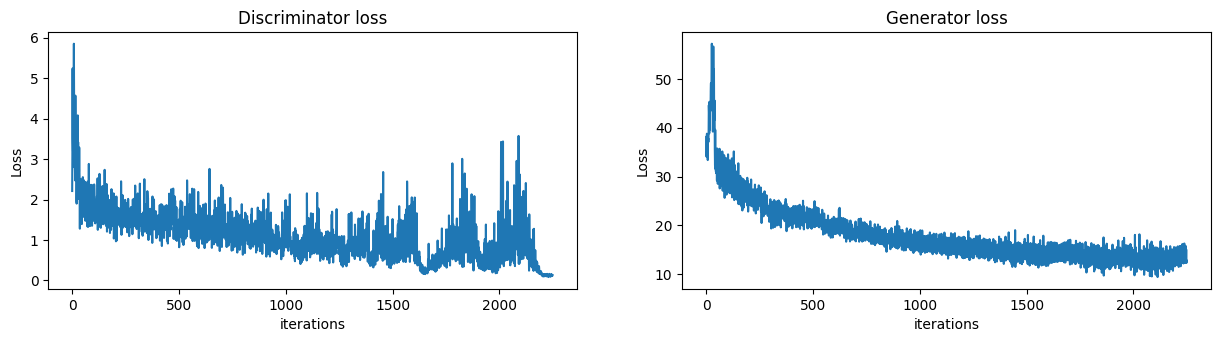

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10/3))

# Plot each list on its corresponding subplot
axs[0].plot(D_losses)
axs[0].set_title('Discriminator loss')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('Loss')

axs[1].plot(G_losses)
axs[1].set_title('Generator loss')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('Loss')

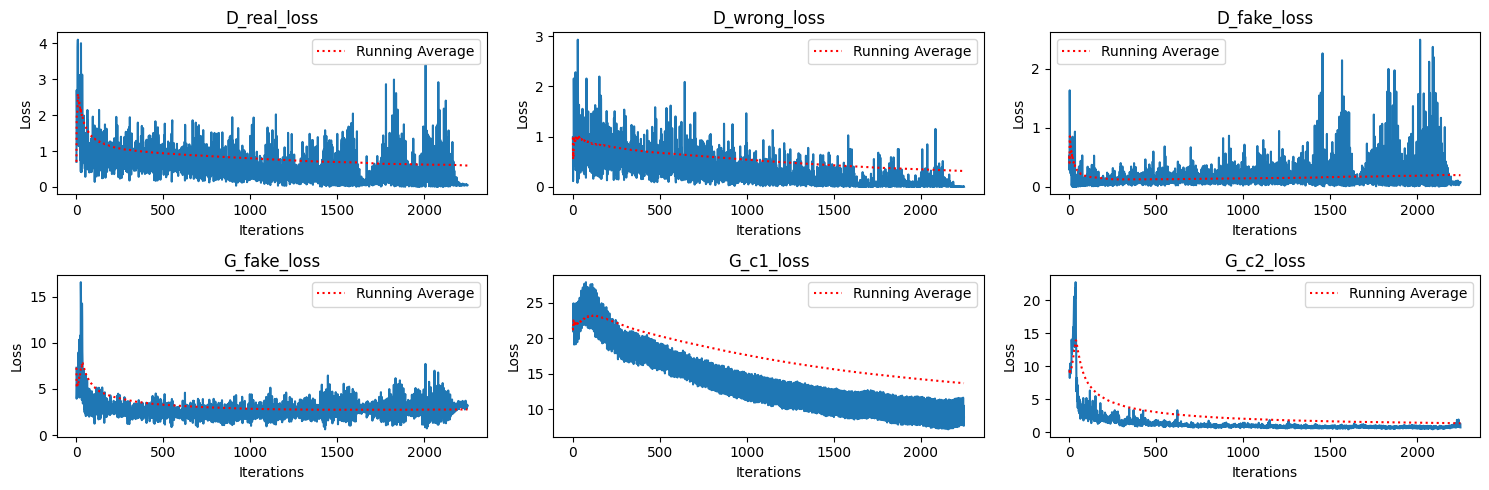

In [47]:
fig2, axs2 = plt.subplots(2, 3, figsize=(15, 10/2))

# Plot each list on its corresponding subplot
for i, losses in enumerate([D_real_losses, D_wrong_losses, D_fake_losses, G_fake_losses, G_c1_losses, G_c2_losses]):
    row = i // 3
    col = i % 3
    ax = axs2[row, col]

    ax.plot(losses)
    ax.set_title(f'{["D_real", "D_wrong", "D_fake", "G_fake", "G_c1", "G_c2"][i]}_loss')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')

    # Calculate the running averages
    running_averages = [np.mean(losses[:j+1]) for j in range(len(losses))]

    # Plot the running averages as a red line
    ax.plot(running_averages, color='r', linestyle=':', label='Running Average')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()